In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import seaborn as sns
# import mpl_scatter_density
%matplotlib inline
sns.set_style('white')
sns.set_context('talk')

In [3]:
def l(x, c=1.0):
    return np.log2(x+1)

In [81]:
ind_cols = {'SLA' : 'target_id', 'hera' : 'target_id', 'polyester' : 'transcript_id', 'kallisto' : 'Name',\
            'salmon (Bowtie2)' : 'target_id', 'salmon (STAR)' : 'target_id'}
read_cols = {'SLA' : 'NumReads', 'hera' : 'est_counts', 'polyester' : 'count', 'kallisto' : 'est_counts', \
             'salmon (Bowtie2)' : 'NumReads', 'salmon (STAR)' : 'NumReads'}

def readSalmon(fn, suf):
    x = pd.read_table(fn)
    x['target_id'] = x['Name'].str.split(':').str.get(0)
    x = x.drop('Name', axis=1)
    rename_dict = { v : '{}_{}'.format(v, suf) for v in x.columns.values if v != ind_cols['SLA'] }
    x = x.rename(index=str, columns=rename_dict)
    return x

def readPolyester(fn, suf):
    x = pd.read_table(fn)
    rename_dict = { v : '{}_{}'.format(v, suf) for v in x.columns.values if v != ind_cols['polyester'] }
    x = x.rename(index=str, columns=rename_dict)
    return x

def readKallisto(fn, suf):
    x = pd.read_table(fn)
    x['Name'] = x['target_id'].str.split(':').str.get(0)
    x = x.drop('target_id', axis=1)
    rename_dict = { v : '{}_{}'.format(v, suf) for v in x.columns.values if v != ind_cols['kallisto'] }
    x = x.rename(index=str, columns=rename_dict)
    return x

def readHera(fn, suf):
    x = pd.read_table(fn, skiprows=1, header=None, \
                      names=['temp', 'unique_map', 'length', 'eff_length', 'est_counts', 'tpm'])
    x['target_id'] = x['temp'].str.split(':').str.get(0)
    x = x.drop('temp', axis=1)
    rename_dict = { v : '{}_{}'.format(v, suf) for v in x.columns.values if v != ind_cols['hera'] }
    x = x.rename(index=str, columns=rename_dict)
    return x

In [82]:
loaders = {'SLA' : readSalmon, 'salmon (Bowtie2)' : readSalmon, 'salmon (STAR)' : readSalmon,\
           'kallisto' : readKallisto, 'hera' : readHera, 'polyester' : readPolyester}

In [83]:
def loadMutData(pathdict, suff):
    m = None
    for k, v in pathdict.items():
        totsuff = '{}_{}'.format(k,suff)
        x = loaders[k](v, totsuff)
        if m is not None:
            m = pd.merge(m, x, left_on=mkey, right_on=ind_cols[k], how='outer')
        else:
            m = x
            mkey = ind_cols[k]
    return m

In [84]:
sampnames = ["SRR1215996", "SRR1215997", "SRR1215998", "SRR1215999", "SRR1216000"]
mrate_dict = {mrate : \
             {'hera' : '/mnt/scratch4/SLA-benchmarking/clean-benchmarks/selective-alignment-experiment/quant_scripts/samples/{}/result.hera1.2/abundance.tsv'.format(mrate),
             'SLA' : '/mnt/scratch4/SLA-benchmarking/clean-benchmarks/selective-alignment-experiment/quant_scripts/samples/{}/result.SLA09.k25.d7/quant.sf'.format(mrate),
             'salmon (Bowtie2)' : '/mnt/scratch4/SLA-benchmarking/clean-benchmarks/selective-alignment-experiment/quant_scripts/samples/{}/result.bowtie2.quant/quant.sf'.format(mrate),
             'salmon (STAR)' : '/mnt/scratch4/SLA-benchmarking/clean-benchmarks/selective-alignment-experiment/quant_scripts/samples/{}/result.star.quant/quant.sf'.format(mrate),
             'kallisto' : '/mnt/scratch4/SLA-benchmarking/clean-benchmarks/selective-alignment-experiment/quant_scripts/samples/{}/result.kallisto.k25/abundance.tsv'.format(mrate)} \
             for mrate in sampnames}

In [85]:
mut_quants = {n : loadMutData(mrate_dict[n], "{}".format(n)) for n in sampnames}

In [99]:
def draw_mut_hexbins(m, mrate, saveas=None):
    #f, axes = plt.subplots(2, 3, sharex=True, figsize=(18, 12))
    fig = plt.figure(figsize=(15,10))
    plt.suptitle("Sample {}".format(mrate))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,1), colspan=2)
    ax2 = plt.subplot2grid((2,6), (0,3), colspan=2)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
    plt.subplots_adjust(wspace=0.8)
    
    ax4.hexbin(l(m[mrate]['NumReads_salmon (Bowtie2)_{}'.format(mrate)].values), \
               l(m[mrate]['NumReads_SLA_{}'.format(mrate)].values), \
               mincnt=1, gridsize=100, bins='log', cmap='jet')
    ax4.set_ylabel("$\log_2$(salmon (SLA) + 1)")
    ax4.set_xlabel("$\log_2$(salmon (Bowtie2) + 1)")

    ax5.hexbin(l(m[mrate]['NumReads_salmon (Bowtie2)_{}'.format(mrate)].values), \
               l(m[mrate]['NumReads_salmon (STAR)_{}'.format(mrate)].values), \
               mincnt=1, gridsize=100, bins='log', cmap='jet')
    ax5.set_ylabel("$\log_2$(salmon (STAR) + 1)")
    ax5.set_xlabel("$\log_2$(salmon (Bowtie2) + 1)")

    ax1.hexbin(l(m[mrate]['NumReads_salmon (Bowtie2)_{}'.format(mrate)].values), \
               l(m[mrate]['est_counts_kallisto_{}'.format(mrate)].values), \
               mincnt=1, gridsize=100, bins='log', cmap='jet')
    ax1.set_ylabel("$\log_2$(kallisto + 1)")
    ax1.set_xlabel("$\log_2$(salmon (Bowtie2) + 1)")

    ax2.hexbin(l(m[mrate]['NumReads_salmon (Bowtie2)_{}'.format(mrate)].values), \
               l(m[mrate]['est_counts_hera_{}'.format(mrate)].values), \
               mincnt=1, gridsize=100, bins='log', cmap='jet')
    ax2.set_ylabel("$\log_2$(hera + 1)")
    ax2.set_xlabel("$\log_2$(salmon (Bowtie2) + 1)")
    plt.suptitle("Sample {}".format(mrate))
    if saveas:
        plt.savefig(saveas)

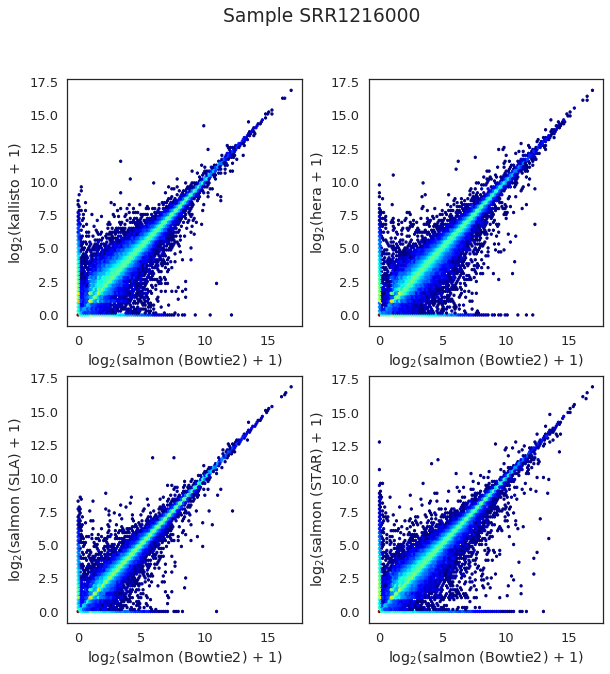

In [105]:
draw_mut_hexbins(mut_quants, "SRR1216000", saveas='scatter_SRR1216000.pdf')